
|RANDOM FOREST| 
-----------------------

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
from pandas.plotting import parallel_coordinates
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import *
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import os
from sklearn.metrics import *
from imblearn.metrics import specificity_score

from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import os
from sklearn.ensemble import RandomForestClassifier

In [8]:
#Importación de los cojuntos de train y test ya separados en el Proyecto de Árboles:

train_data = pd.read_csv("../data/processed/clean_train.csv")
test_data = pd.read_csv("../data/processed/clean_test.csv")

In [3]:
train_data.head()

,Pregnancies,Glucose,BloodPressure,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,5.0,106.0,82.0,0.0,39.5,0.286,38.0,0
1,8.0,109.0,76.0,114.0,27.9,0.640,31.0,1
2,6.0,129.0,90.0,326.0,19.6,0.582,60.0,0
3,3.0,90.0,78.0,0.0,42.7,0.559,21.0,0
4,6.0,102.0,82.0,0.0,30.8,0.180,36.0,1


In [4]:
#Se separa la arabe Objetivo del Conjunto de Train y Test:

X_train = train_data.drop(["Outcome"], axis = 1)
y_train = train_data["Outcome"]
X_test = test_data.drop(["Outcome"], axis = 1)
y_test = test_data["Outcome"]

**Modelización:**

In [9]:
#En esta ocación pasamos unos hiperparámetros simples: 

model = RandomForestClassifier(n_estimators = 10, random_state = 42, max_depth=2, min_samples_leaf=16, max_features=4)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, max_features=4, min_samples_leaf=16,
                       n_estimators=10, random_state=42)

In [14]:
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)


In [19]:
print(f"La accuracy para el Conjunto de Train es del {round(accuracy_score(y_train, y_train_pred),2)*100} %")
print(f"La accuracy para el Conjunto de Test es del {round(accuracy_score(y_test, y_test_pred),2)*100} %")


La accuracy para el Conjunto de Train es del 77.0 %
La accuracy para el Conjunto de Test es del 72.0 %


Métricas del Modelo: 

In [24]:
def get_metrics(y_train, y_test, y_pred_train, y_pred_test):

    # Calcular métricas para el conjunto de entrenamiento
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_specificity = specificity_score(y_train, y_pred_train)

    # Calcular métricas para el conjunto de prueba
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_specificity = specificity_score(y_test, y_pred_test)

    # Calcular la diferencia entre métricas de entrenamiento y prueba
    diff_accuracy = train_accuracy - test_accuracy
    diff_f1 = train_f1 - test_f1
    diff_auc = train_auc - test_auc
    diff_precision = train_precision - test_precision
    diff_recall = train_recall - test_recall
    diff_specificity = train_specificity - test_specificity

    # Crear un DataFrame con los resultados
    metrics_df = pd.DataFrame([[train_accuracy, train_f1, train_auc, train_precision, train_recall, train_specificity],[test_accuracy, test_f1, test_auc, test_precision, test_recall, test_specificity],[diff_accuracy, diff_f1, diff_auc, diff_precision, diff_recall, diff_specificity]],
                              columns = ['Accuracy', 'F1', 'AUC', 'Precision', 'Recall', 'Specificity'],
                              index = ['Train','Test', 'Diferencia'])
    
    return metrics_df

In [25]:
get_metrics(y_train, y_test, y_train_pred, y_test_pred)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.771331,0.605882,0.709843,0.725352,0.520202,0.899485
Test,0.721088,0.539326,0.663082,0.685714,0.444444,0.881720
Diferencia,0.050243,0.066557,0.046761,0.039638,0.075758,0.017764


Es particularmente baja la Recall, lo que significa que el modelo presenta un bajo rendimient en la correcta identificación de los casos positivos. 

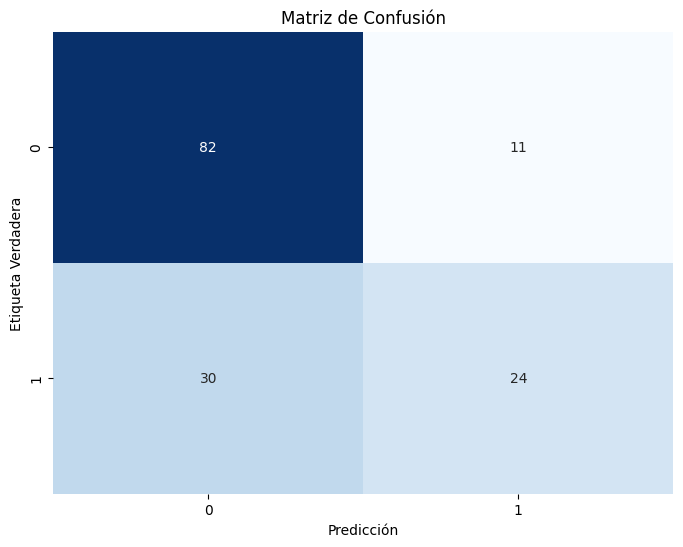

In [26]:
#Confusion Matrix del Conjunto de Test

conf_matrix = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.show()

***BÚSUEDA DE HIPERPARÁMETROS***

In [29]:
hp_dic = {'n_estimators': randint(5, 150),
    'criterion': ['gini', 'entropy', 'log_loss'], 
    'max_depth': randint(1, 25),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': [None], 
    'bootstrap': [True, False]}

random_search= RandomizedSearchCV(estimator=model,param_distributions=hp_dic, n_iter=120, cv=5, random_state=10, n_jobs=1, scoring='f1', verbose=1 )
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(max_depth=2, max_features=4,
                                                    min_samples_leaf=16,
                                                    n_estimators=10,
                                                    random_state=42),
                   n_iter=120, n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f129a4e6080>,
                                        'max_features': [None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f12982b6e30>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f1298143e20>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f1298b2fc10>},
                   random_state=10, scoring='f1', verbose=1)

In [31]:
random_search.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=14, max_features=None,
                       min_samples_leaf=12, min_samples_split=19,
                       n_estimators=120, random_state=42)

In [30]:
best_estimators = random_search.best_estimator_

In [32]:
y_train_pred_opt = best_estimators.predict(X_train)
y_test_pred_opt = best_estimators.predict(X_test)

*Mértricas de Rendimiento para el modelo optimizado tras la búsqueda de Hiperparámetros:*

In [33]:
get_metrics(y_train, y_test, y_train_pred_opt, y_test_pred_opt)

,Accuracy,F1,AUC,Precision,Recall,Specificity
Train,0.860068,0.780749,0.830027,0.829545,0.737374,0.922680
Test,0.761905,0.653465,0.730287,0.702128,0.611111,0.849462
Diferencia,0.098163,0.127283,0.099740,0.127418,0.126263,0.073218


Hay una buena mejoría en términos de Exactitut, pero lo más notable es la mejor capacidad del modelo de discriminar los casos positivos (Recall)

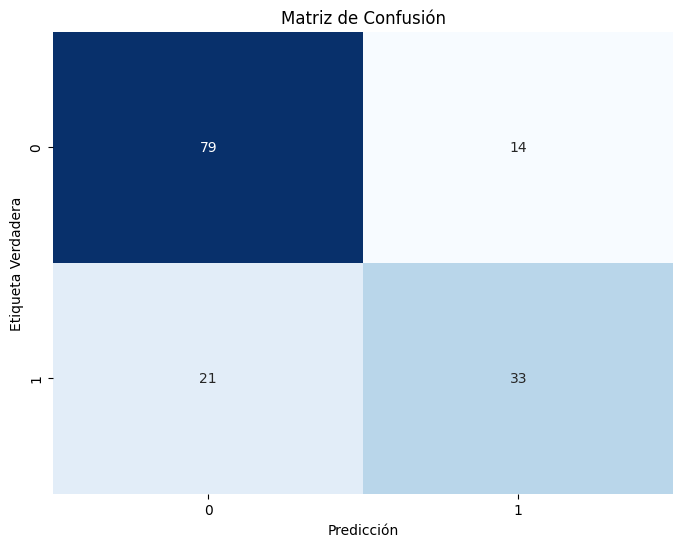

In [35]:
conf_matrix = confusion_matrix(y_test, y_test_pred_opt)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.show()